# «Friedman Test» from Demsar (2006)
Adapted from cgosorio's work.

In [2]:
import os.path
import scipy.stats
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table

In [66]:
np.set_printoptions(formatter={'float_kind': "{:6.3f}".format})
#np.set_printoptions(precision=4)
RED='\033[0;31m'
GRN='\033[0;32m'
NC='\033[0m'
BLD='\033[1m'

In [67]:
metric = 'f1-score'
results_path = os.path.join('ranks', 'results.csv')

In [68]:
results_df = pd.read_csv(results_path)

In [69]:
filters = results_df['filter'].unique()
base_estimators = results_df['base'].unique()
percents_labeled = results_df['percent labeled'].unique()
datasets = results_df['dataset'].unique()
percents_labeled.sort()

print(f"Base estimators used: {base_estimators}")
print(f"Filters used: {filters}")
print(f"Percents labeled used: {percents_labeled}")
print(f"# Datasets used: {len(datasets)}")


Base estimators used: ['KNeighborsClassifier' 'DecisionTreeClassifier' 'GaussianNB']
Filters used: ['ENN' 'LSSm' 'ENANE' 'base']
Percents labeled used: [ 0.050  0.100  0.150  0.200  0.250  0.300  0.350]
# Datasets used: 18


In [70]:
grouped_df = results_df.groupby(['dataset', 'percent labeled',
                                              'base', 'filter']).mean()

grouped_df = grouped_df[metric].to_frame()
grouped_df.reset_index(inplace=True)

bases_filters = np.array(list(product(base_estimators, filters)))
print("Pairs of base estimator with filters:\n", bases_filters)

Pairs of base estimator with filters:
 [['KNeighborsClassifier' 'ENN']
 ['KNeighborsClassifier' 'LSSm']
 ['KNeighborsClassifier' 'ENANE']
 ['KNeighborsClassifier' 'base']
 ['DecisionTreeClassifier' 'ENN']
 ['DecisionTreeClassifier' 'LSSm']
 ['DecisionTreeClassifier' 'ENANE']
 ['DecisionTreeClassifier' 'base']
 ['GaussianNB' 'ENN']
 ['GaussianNB' 'LSSm']
 ['GaussianNB' 'ENANE']
 ['GaussianNB' 'base']]


In [71]:
print(grouped_df)

                    dataset  percent labeled                    base filter  \
0          BreastTissue.csv             0.05  DecisionTreeClassifier  ENANE   
1          BreastTissue.csv             0.05  DecisionTreeClassifier    ENN   
2          BreastTissue.csv             0.05  DecisionTreeClassifier   LSSm   
3          BreastTissue.csv             0.05  DecisionTreeClassifier   base   
4          BreastTissue.csv             0.05              GaussianNB  ENANE   
...                     ...              ...                     ...    ...   
1507  wifi-localization.csv             0.35              GaussianNB   base   
1508  wifi-localization.csv             0.35    KNeighborsClassifier  ENANE   
1509  wifi-localization.csv             0.35    KNeighborsClassifier    ENN   
1510  wifi-localization.csv             0.35    KNeighborsClassifier   LSSm   
1511  wifi-localization.csv             0.35    KNeighborsClassifier   base   

      f1-score  
0     0.183905  
1     0.196561  


In [72]:
def base_filter_values():
    values = pd.DataFrame()
    for base_filter in bases_filters:
        base_, filter_ = base_filter
        working_df = grouped_df.loc[
            (grouped_df['percent labeled'] == percent) &
            (grouped_df['base'] == base_) &
            (grouped_df['filter'] == filter_)
            ]
        value = working_df[metric].to_frame()
        value.reset_index(inplace=True, drop=True)
        value.columns = [':'.join(base_filter)]
        values = pd.concat((value, values), axis=1)

    return values


def split_onto_base_estimators():
    for base_ in base_estimators:
        base_dfs.append(curr_vals.filter(regex=base_))

In [10]:
data = []

In [75]:
data = []
for percent in percents_labeled:
    curr_vals = base_filter_values()

    base_dfs = list()
    split_onto_base_estimators()
    print('\n\n------------------------------------\n\n> Percent labeled: ',
          percent)
    for base, df in zip(base_estimators, base_dfs):
        metric_vals = df.to_numpy()

        N, k = len(datasets), len(df.columns)
        assert N==metric_vals.shape[0] and k==metric_vals.shape[1]

        rankings = scipy.stats.rankdata(-metric_vals, axis=1)

        Rj = average_ranks = np.mean(rankings, axis=0)

        average_rank_tuples = sorted(zip(df.columns, average_ranks), key=lambda
            a: a[1])

        average_rank_for = {method: value for method,
                                              value in zip(df.columns,
                                                           average_ranks)}
        print()
        for key, value in average_rank_for.items():
            print(key, f'{value:.2f}')
            
            
        part0 = (12*N)/(k*(k+1))
        part1 = sum([Rj**2 for Rj in average_ranks])
        part2 = (k*(k+1)**2)/4     
        𝛘2_F = part0*(part1-part2)
        F_F = (N-1)*𝛘2_F/(N*(k-1)-𝛘2_F)
        
        data.append([percent, F_F, average_rank_for, N, k])  



------------------------------------

> Percent labeled:  0.05

KNeighborsClassifier:base 2.47
KNeighborsClassifier:ENANE 2.25
KNeighborsClassifier:LSSm 2.67
KNeighborsClassifier:ENN 2.61

DecisionTreeClassifier:base 2.39
DecisionTreeClassifier:ENANE 2.94
DecisionTreeClassifier:LSSm 2.00
DecisionTreeClassifier:ENN 2.67

GaussianNB:base 2.22
GaussianNB:ENANE 2.14
GaussianNB:LSSm 2.39
GaussianNB:ENN 3.25


------------------------------------

> Percent labeled:  0.1

KNeighborsClassifier:base 2.78
KNeighborsClassifier:ENANE 2.78
KNeighborsClassifier:LSSm 2.22
KNeighborsClassifier:ENN 2.22

DecisionTreeClassifier:base 2.72
DecisionTreeClassifier:ENANE 2.50
DecisionTreeClassifier:LSSm 2.44
DecisionTreeClassifier:ENN 2.33

GaussianNB:base 3.17
GaussianNB:ENANE 2.00
GaussianNB:LSSm 2.17
GaussianNB:ENN 2.67


------------------------------------

> Percent labeled:  0.15

KNeighborsClassifier:base 2.50
KNeighborsClassifier:ENANE 2.44
KNeighborsClassifier:LSSm 2.78
KNeighborsClassifier:ENN 

# Ivan And Davenport 
F_F = (N-1)*𝛘2_F/(N*(k-1)-𝛘2_F)

https://www.statology.org/f-distribution-calculator/

With 3 classifiers, 3 filters and the base one, and 18 data sets, $F_F$ is distributed according to the $F$ distribution with
$7-1=6$ and $(7-1)×(18−1)=102$ degrees of freedom. The critical value of $F(6,102)$ for $\alpha=0.05$
is $2.00002$, so we reject the null-hypothesis

In [12]:
# Using critical values
# FROM: https://stackoverflow.com/questions/39813470/f-test-with-python-finding-the-critical-value
# SEE ALSO: https://www.statology.org/f-critical-value-python/
alpha = 0.05
for percent, F_F, average_rank_for, N, k in data:
    critical_value = scipy.stats.f.ppf(q=1-alpha, dfn=(k-1), dfd=(k-1)*(N-1))

    if F_F > critical_value:
        print(f"{GRN}We reject the null-hypothesis, as the F_F value ({F_F:.3}) is greater than the critical value ({critical_value:.3})")
        print(f"{BLD}That means that there are statistically differences between classifiers{NC}")
    else:
        print(f"{RED}We CAN NOT reject the null-hypothesis, as the F_F value ({F_F:.3}) is less than the critical value ({critical_value:.3})")
        print(f"{BLD}That means that there are not statistically differences between classifiers{NC}")
        #print(f"Or that the test is not powerfull enough to detect the differences")

We CAN NOT reject the null-hypothesis, as the F_F value (0.359) is less than the critical value (2.79)
That means that there are not statistically differences between classifiers
We CAN NOT reject the null-hypothesis, as the F_F value (1.84) is less than the critical value (2.79)
That means that there are not statistically differences between classifiers
We reject the null-hypothesis, as the F_F value (3.15) is greater than the critical value (2.79)
That means that there are statistically differences between classifiers
We CAN NOT reject the null-hypothesis, as the F_F value (1.12) is less than the critical value (2.79)
That means that there are not statistically differences between classifiers
We CAN NOT reject the null-hypothesis, as the F_F value (0.277) is less than the critical value (2.79)
That means that there are not statistically differences between classifiers
We reject the null-hypothesis, as the F_F value (3.4) is greater than the critical value (2.79)
That means that there

# Autoranking

Usage of the autoranking library

In [76]:

results = {}

for percent in percents_labeled:
    curr_vals = base_filter_values()

    base_dfs = list()
    split_onto_base_estimators()
    print(percent, end=' ')
    for base, df in zip(base_estimators, base_dfs):
        metric_vals = df.to_numpy()
        result = autorank(df, alpha=0.05, verbose=False, approach='frequentist')
        results[tuple((percent, base))] = result
    print('✅')

0.05 ✅
0.1 ✅
0.15 ✅
0.2 ✅
0.25 ✅
0.3 ✅
0.35 ✅


### Reports for each percent and base estimator


In [143]:
def print_report(percent, base, report):
    print(f'{GRN}> Percent labeled: {NC}', percent, f'\n{GRN}> Base Estimator:  {NC}', base, end='\n\n')
    create_report(report)
    plot_stats(result, allow_insignificant=True)
    plt.savefig(f'result_plots/{percent}_{base}.png')

In [144]:
keys_list = list(results.keys())
print(len(keys_list))

21


> Percent labeled:  0.05 
> Base Estimator:   KNeighborsClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.018). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.999) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each

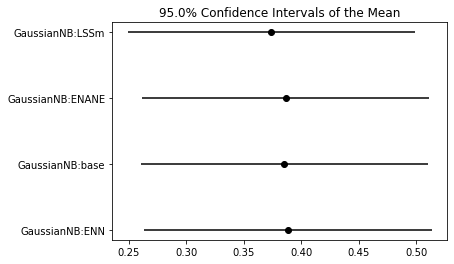

In [145]:
percent, base = keys_list[0]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.05 
> Base Estimator:   DecisionTreeClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.020). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.994) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for ea

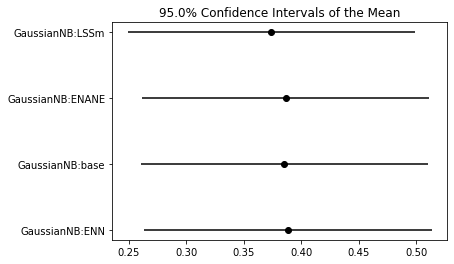

In [146]:
percent, base = keys_list[1]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.05 
> Base Estimator:   GaussianNB

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.020). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.991) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each populatio

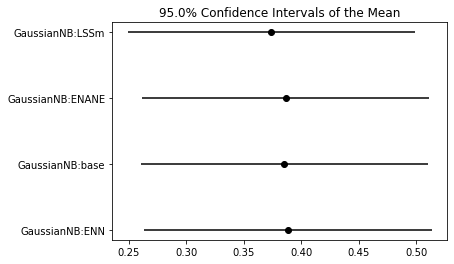

In [147]:
percent, base = keys_list[2]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.1 
> Base Estimator:   KNeighborsClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.085). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.998) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each 

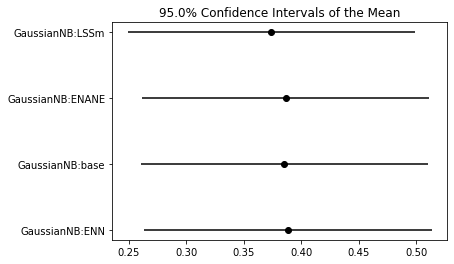

In [148]:
percent, base = keys_list[3]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.1 
> Base Estimator:   DecisionTreeClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.054). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.998) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for eac

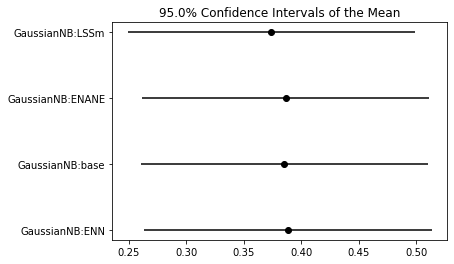

In [149]:
percent, base = keys_list[4]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.1 
> Base Estimator:   GaussianNB

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.042). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.999) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population

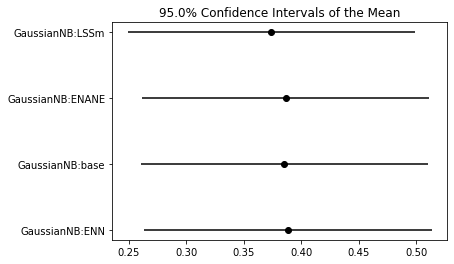

In [150]:
percent, base = keys_list[5]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.15 
> Base Estimator:   KNeighborsClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.045). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.994) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each

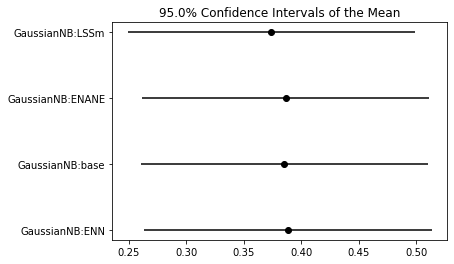

In [151]:
percent, base = keys_list[6]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.15 
> Base Estimator:   DecisionTreeClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.040). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.999) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for ea

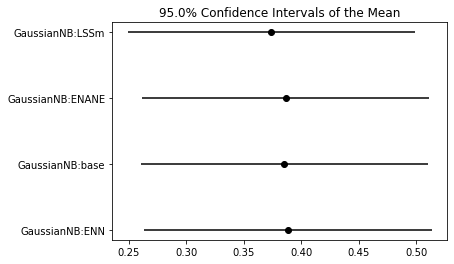

In [152]:
percent, base = keys_list[7]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.15 
> Base Estimator:   GaussianNB

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.049). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.997) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each populatio

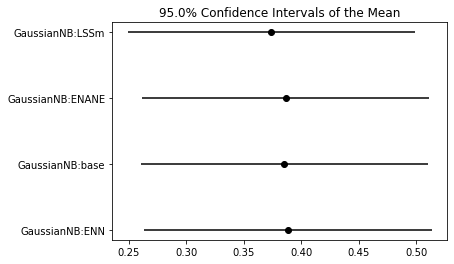

In [153]:
percent, base = keys_list[8]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.2 
> Base Estimator:   KNeighborsClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.058). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.999) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each 

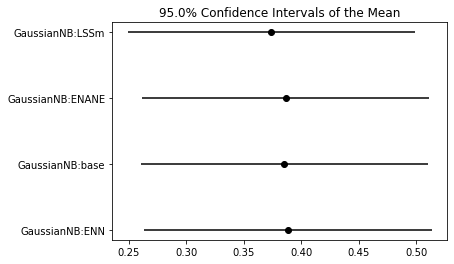

In [154]:
percent, base = keys_list[9]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.2 
> Base Estimator:   DecisionTreeClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.031). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.999) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for eac

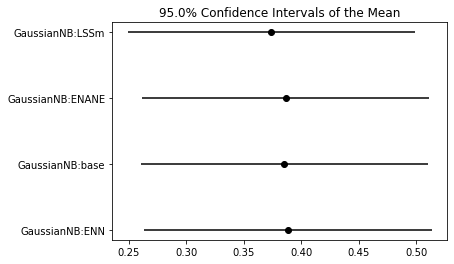

In [155]:
percent, base = keys_list[10]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.2 
> Base Estimator:   GaussianNB

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.031). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.998) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population

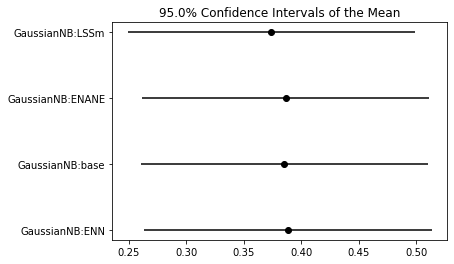

In [156]:
percent, base = keys_list[11]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.25 
> Base Estimator:   KNeighborsClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.029). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.994) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each

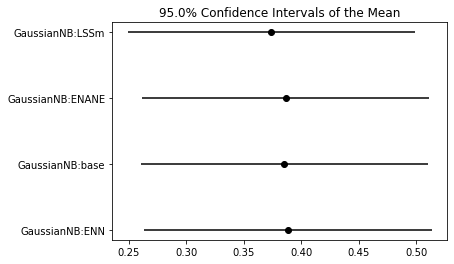

In [157]:
percent, base = keys_list[12]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.25 
> Base Estimator:   DecisionTreeClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.017). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=1.000) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for ea

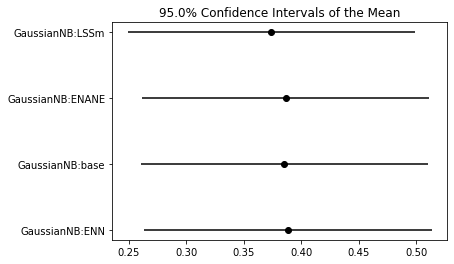

In [158]:
percent, base = keys_list[13]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.25 
> Base Estimator:   GaussianNB

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.020). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.994) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each populatio

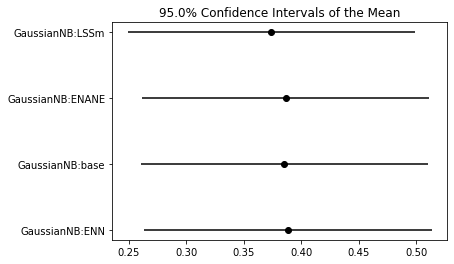

In [159]:
percent, base = keys_list[14]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.3 
> Base Estimator:   KNeighborsClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.024). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.999) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each 

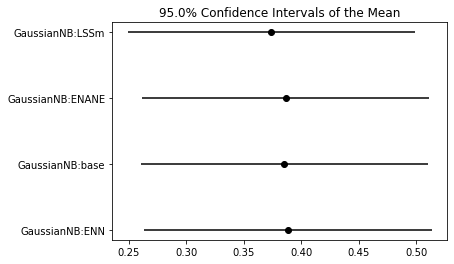

In [160]:
percent, base = keys_list[15]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.3 
> Base Estimator:   DecisionTreeClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.027). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=1.000) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for eac

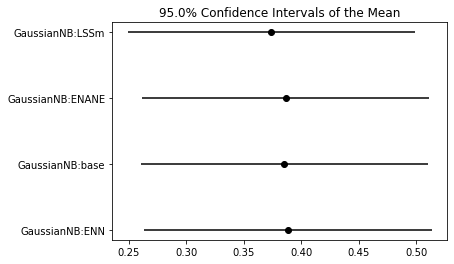

In [161]:
percent, base = keys_list[16]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.3 
> Base Estimator:   GaussianNB

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.019). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.998) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population

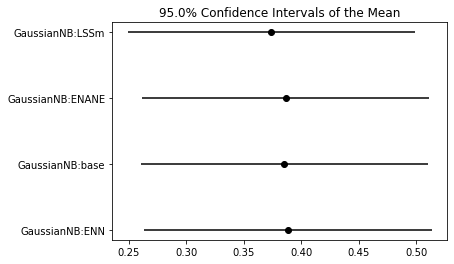

In [162]:
percent, base = keys_list[17]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.35 
> Base Estimator:   KNeighborsClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.021). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=1.000) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each

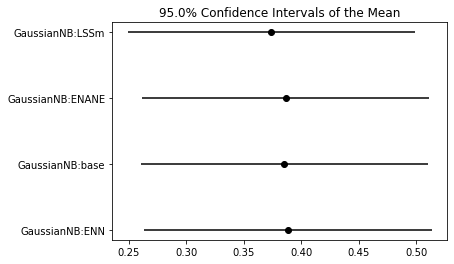

In [163]:
percent, base = keys_list[18]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.35 
> Base Estimator:   DecisionTreeClassifier

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.018). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.999) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for ea

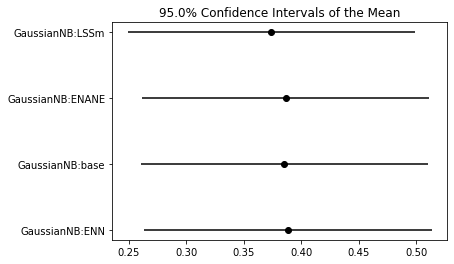

In [164]:
percent, base = keys_list[19]
print_report(percent, base, results[(percent, base)])

> Percent labeled:  0.35 
> Base Estimator:   GaussianNB

The statistical analysis was conducted for 4 populations with 18 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.025). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.999) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each populatio

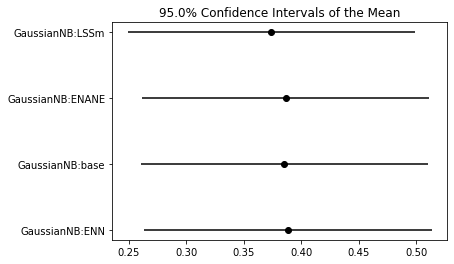

In [165]:
percent, base = keys_list[20]
print_report(percent, base, results[(percent, base)])